In [1]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [2]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
# path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/home/shaun/.fastai/data/mnist.pkl.gz')

In [5]:
# with gzip.open(path, 'rb') as f:
#     ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
# x_train, y_train, x_valid, y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
# n, n_classes = x_train.shape

In [7]:
# x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [13]:
# img = x_train[0] # get one imge
# label = y_train[0]
# img.type()

'torch.FloatTensor'

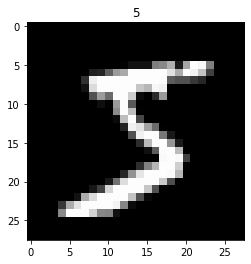

In [16]:
# plt.title(label.numpy())
# plt.imshow(img.view(28,28))

## Matrix mulitply (matmul)
The operation of a a matmul is essentially a dot product of each row by each column

Given two matrices A and B of size n x m. You can only do a matrix multiplication of number of columns in A == number of rows in B.

The new shape will be A number of rows by B number of columns


## TODO

* add links/imgs from deeplearning books

[Kahhn Academy Video](https://www.khanacademy.org/math/precalculus/x9e81a4f98389efdf:matrices/x9e81a4f98389efdf:multiplying-matrices-by-matrices/v/multiplying-a-matrix-by-a-matrix)

[Example](http://matrixmultiplication.xyz/)

In [18]:
weight = torch.randn(784, 10)
bias = torch.zeros(10)

In [20]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    result = torch.zeros(ar,bc)
    for i in range(ac):
           c[i]   = (a[i].unsqueeze(-1) * b).sum(dim=0) # why does this make sense
        
    

[computational linear algebra course](https://github.com/fastai/numerical-linear-algebra)

continue at 1:25

## Relu and Initialising 

In [6]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))



### Normalising data to have mean of 0 and standard deviation of 1

In [8]:
def normalize(data, mean, std): return (data-mean)/std

In [9]:
x_train, y_train, x_valid, y_valid = get_data()

In [10]:
train_mean = x_train.mean()
train_std = x_train.std()

In [11]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

### Check is data is normalised

In [13]:
x_train.std(), x_train.mean()

(tensor(1.), tensor(-6.2598e-06))

In [17]:
num_samples, input_size = x_train.shape
num_classes = y_train.max()+1
num_samples, input_size, num_classes

(50000, 784, tensor(10))

### Basic architecture

Why is normalisation important?

**Papers**: 

[Fixup Initialization](https://arxiv.org/pdf/1901.09321.pdf)

[Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

Read 2.2 until backprob [Delving Deep into Rectifiers](https://arxiv.org/abs/1502.01852)

In [18]:
num_hidden = 50

Simplified kaming init

In [51]:
w1 = torch.randn(input_size, num_hidden)/math.sqrt(input_size) # weights 1
b1 = torch.zeros(num_hidden) # bias 1
w2 = torch.randn(num_hidden, 1)/math.sqrt(num_hidden) # weights 2
b2 = torch.zeros(1)

In [52]:
# Without kaming init
w = torch.randn(input_size, num_hidden)
w.mean(), w.std() # This should be ~ (0,1) (mean,std)

(tensor(-0.0071), tensor(0.9959))

In [50]:
# With kaming init
w = torch.randn(input_size, num_hidden)/math.sqrt(input_size)
w.mean(), w.std() # This should be ~ (0,1) (mean,std)

(tensor(6.6950e-05), tensor(0.0359))

### Creating a linear layer as shown in the image below with relu as the activation function

![Mathematical model of artificial neuron](https://www.researchgate.net/publication/320270458/figure/fig1/AS:551197154254848@1508427050805/Mathematical-model-of-artificial-neuron.png)

In [53]:
def lin(inputs, weights, bias): 
    return inputs@weights + bias # @ symbol is matrix multiplication operation
    

In [54]:
# with Kaiming
y_hat = lin(x_valid, w1, b1)
y_hat.mean(), y_hat.std()

(tensor(-0.0493), tensor(0.9835))

In [55]:
# without Kaiming
y_hat = lin(x_valid, w, b1)
y_hat.mean(), y_hat.std()

(tensor(0.8801), tensor(28.4588))

In [56]:
def relu(x): 
    return x.clamp_min(0.)

In [57]:
# Kaiming
y_hat = relu(lin(x_valid, w1, b1))
y_hat.mean(), y_hat.std()

(tensor(0.3668), tensor(0.5572))

From pytorch docs: `a: the negative slope of the rectifier used after this layer (0 for ReLU by default)`

$$\text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan_in}}}$$

This was introduced in the paper that described the Imagenet-winning approach from *He et al*: [Delving Deep into Rectifiers](https://arxiv.org/abs/1502.01852), which was also the first paper that claimed "super-human performance" on Imagenet (and, most importantly, it introduced resnets!)

In [60]:
# kaiming init / he init for relu
w1 = torch.randn(input_size, num_hidden)*math.sqrt(2/input_size)
w1.mean(), w1.std()

(tensor(-3.1501e-05), tensor(0.0502))

In [61]:
# Updated init
y_hat = relu(lin(x_valid, w1, b1))
y_hat.mean(), y_hat.std()

(tensor(0.5870), tensor(0.8895))

got up to 1:43